Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.
C:\Users\alish\AppData\Local\Temp\ipykernel_28688\1285410189.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j])


Compiling model...
'compile' took 0.000120 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.05e-02, 4.17e-02, 3.43e-01]    [9.01e-03, 4.17e-02, 3.43e-01]    []  
1000      [3.81e-04, 4.65e-05, 3.97e-05]    [2.34e-04, 4.65e-05, 3.97e-05]    []  
2000      [1.72e-04, 1.17e-04, 1.56e-04]    [1.16e-04, 1.17e-04, 1.56e-04]    []  
3000      [9.53e-05, 6.32e-06, 7.34e-06]    [6.28e-05, 6.32e-06, 7.34e-06]    []  
4000      [6.59e-05, 3.88e-06, 4.66e-06]    [4.42e-05, 3.88e-06, 4.66e-06]    []  
5000      [2.36e-04, 1.77e-05, 2.41e-05]    [2.01e-04, 1.77e-05, 2.41e-05]    []  
6000      [3.99e-05, 2.00e-06, 2.52e-06]    [2.74e-05, 2.00e-06, 2.52e-06]    []  
7000      [5.14e-05, 3.09e-06, 4.67e-06]    [4.25e-05, 3.09e-06, 4.67e-06]    []  
8000      [2.82e-05, 1.37e-06, 1.61e-06]    [1.96e-05, 1.37e-06, 1.61e-06]    []  
9000      [2.46e-05, 1.22e-06, 1.31e-06]    [1.71e-05, 1.22e-06, 1.31e-06]    []  
10000     [2.18

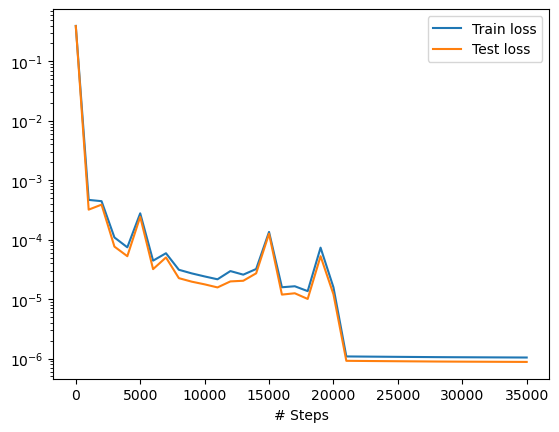

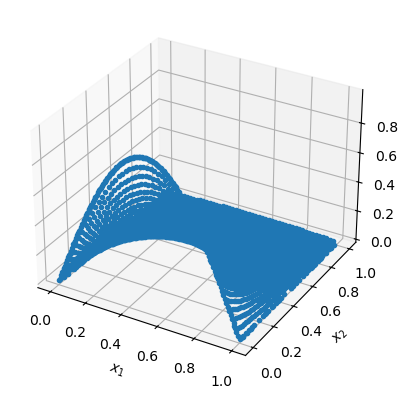

Mean residual: 0.0005824
L2 relative error: 0.0009531330493111441


In [1]:
import deepxde as dde
import numpy as np
import paddle

def heat_eq_exact_solution(x, t):
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

def gen_exact_solution():
    x_dim, t_dim = (256, 201)

    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])
    np.savez("heat_eq_data", x=x, t=t, usol=usol)

def gen_testdata():
    data = np.load("heat_eq_data.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

a = 0.4  
L = 1  
n = 1 

gen_exact_solution()

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

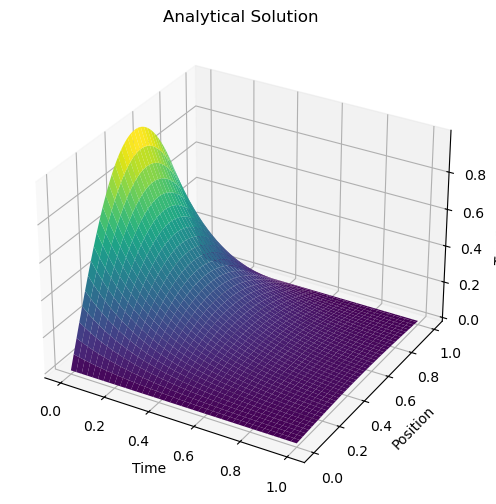

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def heat_eq_exact_solution(x, t, n, a, L):
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)
a = 0.4  
L = 1   
n = 1   

x_dim, t_dim = 256, 201
x_vals = np.linspace(0, L, x_dim)
t_vals = np.linspace(0, 1.0, t_dim)
xx, tt = np.meshgrid(x_vals, t_vals)

analytical_solution = heat_eq_exact_solution(xx, tt, n, a, L)
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(tt, xx, analytical_solution, cmap='viridis')
ax1.set_title('Analytical Solution')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_zlabel('Temperature')
plt.show()

Compiling model...
'compile' took 0.000360 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [6.75e-03, 1.25e-02, 3.88e-01, 3.63e-03]    [6.69e-03, 1.25e-02, 3.88e-01, 3.63e-03]    [8.89e-01]    
0 [1.00e+00]
1000      [7.70e-04, 4.03e-04, 3.04e-04, 1.32e-05]    [4.37e-04, 4.03e-04, 3.04e-04, 1.32e-05]    [3.05e-01]    
1000 [5.94e-01]
2000      [1.85e-04, 1.29e-04, 7.20e-05, 8.41e-06]    [9.40e-05, 1.29e-04, 7.20e-05, 8.41e-06]    [3.51e-01]    
2000 [5.50e-01]
3000      [7.21e-05, 5.36e-05, 2.46e-05, 3.50e-06]    [4.04e-05, 5.36e-05, 2.46e-05, 3.50e-06]    [3.76e-01]    
3000 [5.28e-01]
4000      [1.72e-04, 6.99e-05, 1.63e-05, 2.72e-05]    [1.38e-04, 6.99e-05, 1.63e-05, 2.72e-05]    [3.75e-01]    
4000 [5.17e-01]
5000      [1.72e-04, 2.95e-05, 1.28e-05, 8.88e-05]    [1.32e-04, 2.95e-05, 1.28e-05, 8.88e-05]    [4.13e-01]    
5000 [5.11e-01]
6000      [1.86e-05, 8.74e-06, 3.09e-06, 6.66e-06] 

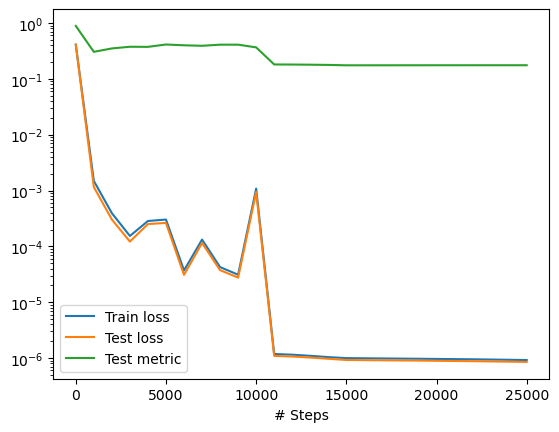

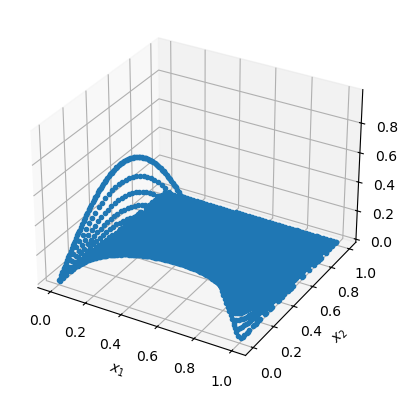

AttributeError: 'VariableValue' object has no attribute 'values'

In [3]:
C = dde.Variable(1.0)
n = 1
L = 1.0
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - C * dy_xx
def func(x):
    return paddle.exp(-(n**2 * np.pi**2 * C.numpy() * x[:, 1:]) / (L**2)) * np.sin(n * np.pi * x / L)
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)
observe_x = np.vstack((np.linspace(0, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    anchors=observe_x,
    solution=func,
    num_test=2540,
)
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
C = dde.Variable(1.0)
model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=[C]
)
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=10000, callbacks=[variable])
model.compile("L-BFGS", metrics=["l2 relative error"], external_trainable_variables=[C])
losshistory, train_state = model.train(callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
C_values = variable.values
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000) + [10000] * len(C_values[10:]), C_values, marker='o')
plt.xlabel("Iterations")
plt.ylabel("C Value")
plt.title("C Value over Iterations")
plt.grid(True)
plt.show()